## MultiNLI (Multi-Genre Natural Language Inference)
MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제


In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


In [3]:
import torch
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 데이터셋 구성 요소

모델 학습에 필요한 '전제, 가설, 라벨' 형태로 가공한다.



*   premise (전제)
*   hypothesis (가설)
* labels (라벨)

✅ 라벨의 종류
* **함의(Entailment)**: 전제가 가설을 지 지하는 경우.​ -> 0

* **중립(Neutral)**: 전제가 가설에 대해 중립적이거나 관련이 없는 경우. -> 1

* **모순(Contradiction)**: 전제가 가설과 모순되는 경우.​ -> 2



In [4]:
import random
import pandas as pd


def load_data(path, nrows=None):
  # nrows : 최대 몇줄까지 처리할 것인지 정함
  # keep_default_na : 빈 문자열을 그대로 유지
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data


train_data = load_data(path + '/train.csv', nrows=1000)
test_data = load_data(path + '/validation_matched.csv', nrows=1000)

In [5]:
train_data[0], test_data[0]

({'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
  'hypothesis': 'Product and geography are what make cream skimming work. ',
  'label': 1},
 {'premise': 'The new rights are nice enough',
  'hypothesis': 'Everyone really likes the newest benefits ',
  'label': 1})

In [6]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['premise'] + row['hypothesis'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_data, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_data, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [7]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    #사전 학습한 BERT 모델
    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')
    #클래스 3개!
    self.classifier = nn.Linear(768, 3)

  def forward(self, x):
    #last_hidden_state : 각 토큰에 대해 의미를 담은 벡터
    #어텐션이 적용됨
    x = self.encoder(x)['last_hidden_state']
    # 맨 첫번째 CLS 토큰 뽑기
    # BERT에서는 [CLS]가 이 문장이 전체적인 의미를 요약해서 담은 대표 벡터이다.
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

FREEZE!!

## 사전학습 x 트랜스포머

In [9]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    # 입력 벡터 차원
    self.input_dim = input_dim

    # Q, K, V 및 최종 출력 차원
    self.d_model = d_model

    #n_heads 헤드의 개수?!
    self.n_heads = n_heads

    # Q, K, V에 곱할 가중치 행렬값
    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)

    # 은닉층 한 번 선형 결과를 만들어서 정확도를 더 높여준다
    self.dense = nn.Linear(d_model, d_model)

    # 어텐션 스코어 계산에 필요한 소프트맥스. 확률 분포로 변환시켜준다. 0~1사이의 값
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    # Q, K, V 벡터 값 생성
    q, k, v = self.wq(x), self.wk(x), self.wv(x) # (B, S, D)

    # 배치 크기
    B = q.shape[0]
    # 시퀀스 길이
    S = q.shape[1]
    # 임베딩 벡터 차원 근데 얘는 D = H * D' | D' = D // 2 (정수로 나눠야함)
    D_HEAD = self.d_model // self.n_heads

    #Q, K, V를 (B, S, H, D')로 리쉐이프 + (B,H,S,D')로 순서 바꿔줘야함 이런
    q = q.reshape(B, S, self.n_heads, D_HEAD).transpose(1,2)
    k = k.reshape(B, S, self.n_heads, D_HEAD).transpose(1,2)
    v = v.reshape(B, S, self.n_heads, D_HEAD).transpose(1,2)


    # Q * K^T 쿼리와 키의 유사도를 구함
    score = torch.matmul(q, k.transpose(-1, -2)) # (B,H,S,D') * (B,H,D',S) = (B, H, S, S)
    # 스케일링 : 루트 d로 나누어서 크기 조정을 한다.
    score = score / sqrt(self.d_model)

    # 마스킹 - 패딩 토큰 무시. 0에 수렴하도록? 거의 안보이게 하기 위해 -1e9 더함
    # score의 (B, H, S, S) 쉐이프에 맞춰야함
    # 마스크 값의 shape는 (B, 1, S).... 행렬 덧셈 조건에 맞게 차원을 더 추가해서 (B, 1, X, S) 이런식으로 하면 될듯
    if mask is not None:
      mask = mask[:, None]
      score = score + (mask * -1e9)

    # 스코어를 소프트 맥스로 변환
    score = self.softmax(score)
    # 어텐션 스코어를 value의 벡터에 곱해서 문맥을 반영한 최종 벡터 꺼냄
    result = torch.matmul(score, v) # -> (B, S, H, D')

    # (B, S, D)로 리쉐이프
    result = result.transpose(1,2) #(B, H, S, D')
    result = result.reshape((B, S, -1)) #(B,S,D)

    # 최종 출력값 변환
    result = self.dense(result) # -> (B, S, D)

    return result

In [10]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates
# 포지셔널 인코딩
# 트랜스포머를 사용하려면 순서 정보 벡터값을 따로 계산해서 입력해줘야한다.
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [12]:
#트랜스포머
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, n_heads):
    super().__init__()

    self.input_dim = input_dim # 입력 벡터 차원
    self.d_model = d_model # 모델 크기
    self.dff = dff #은닉층 크기

    self.mha = MultiHeadAttention(input_dim, d_model, n_heads) #멀티 헤드 어텐션 계산

    # 그냥 우리가 알고있는 MLP
    # 언어를 학습시키는 데 더 많은 가중치(weight)를 부여함
    # 비선형 처리 + 추가 가중치
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    # residual + 레이어 정규화
    self.norm1 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(0.1)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout2 = nn.Dropout(0.1)

  def forward(self, x, mask):
    x1 = self.mha(x, mask) #1. 멀티헤드 어텐션의 결과를 가져온다.
    x1 = self.dropout1(x1)
    x1 = self.norm1(x + x1)

    x2 = self.ffn(x1)
    x2 = self.dropout2(x2)
    x2 = self.norm2(x1 + x2)

    return x2

In [13]:
class TextClassifierNotPreTrained(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    # 워드 임베딩
    self.embedding = nn.Embedding(vocab_size, d_model)
    # 포지셔널 인코딩
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    # rnn 대신 트랜스포머 레이어를 통과시킴.
    # 인코더, 디코더를 여러개 두고 쓰는 방식이라서 여러개를 만들어서 통과시키는듯
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 3)

  def forward(self, x):
    # x의 shape == (batch_size, seq_len, d_model)
    # 마스크 정의: 패딩 토큰이 있다면 true
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :] # -> (B,1,S)?

    # 시퀀스 데이터의 길이
    seq_len = x.shape[1]

    # 워드 임베딩
    x = self.embedding(x)
    # 노멀라이즈?
    x = x * sqrt(self.d_model)
    # 포지셔널 인코딩 - 위치 정보 벡터 추가
    x = x + self.pos_encoding[:, :seq_len]

    # 트랜스포머의 레이어 갯수만큼 돌려라...
    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0] # 첫번째 차원(배치)에서 모든 요소를 선택, 두번째 차원(시퀀스 데이터) 첫번째 요소만 선택해서 마지막 단어를 예측하게끔 하는듯
    x = self.classification(x)

    return x


modelWithTransformer = TextClassifierNotPreTrained(len(tokenizer), 32, 5, 32, 4)

In [14]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

train_accs = []
test_accs = []

## 트랜스포머 학습

In [16]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
modelWithTransformer = modelWithTransformer.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(modelWithTransformer.parameters(), lr=lr)
n_epochs = 50
train_losses2 = []
train_accs2 = []
test_accs2 = []

for epoch in range(n_epochs):
  total_loss = 0.
  modelWithTransformer.train()
  for data in train_loader:
    modelWithTransformer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = modelWithTransformer(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  train_losses2.append(avg_loss)

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    modelWithTransformer.eval()
    train_acc = accuracy(modelWithTransformer, train_loader)
    test_acc = accuracy(modelWithTransformer, test_loader)

    train_accs2.append(train_acc)
    test_accs2.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 17.9515460729599
=========> Train acc: 0.376 | Test acc: 0.341
Epoch   1 | Train Loss: 17.3117413520813
=========> Train acc: 0.381 | Test acc: 0.345
Epoch   2 | Train Loss: 17.29813301563263
=========> Train acc: 0.423 | Test acc: 0.351
Epoch   3 | Train Loss: 16.930431485176086
=========> Train acc: 0.483 | Test acc: 0.343
Epoch   4 | Train Loss: 16.312215387821198
=========> Train acc: 0.511 | Test acc: 0.348
Epoch   5 | Train Loss: 15.25848799943924
=========> Train acc: 0.611 | Test acc: 0.369
Epoch   6 | Train Loss: 13.88969612121582
=========> Train acc: 0.680 | Test acc: 0.355
Epoch   7 | Train Loss: 11.835309565067291
=========> Train acc: 0.750 | Test acc: 0.345
Epoch   8 | Train Loss: 10.523973047733307
=========> Train acc: 0.771 | Test acc: 0.352
Epoch   9 | Train Loss: 8.27728596329689
=========> Train acc: 0.882 | Test acc: 0.344
Epoch  10 | Train Loss: 6.12438777089119
=========> Train acc: 0.912 | Test acc: 0.353
Epoch  11 | Train Loss: 4.401413

## BERT 학습

In [ ]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 50
train_losses = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  train_losses.append(avg_loss)

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 17.999749064445496
=========> Train acc: 0.377 | Test acc: 0.343
Epoch   1 | Train Loss: 17.70098328590393
=========> Train acc: 0.396 | Test acc: 0.343
Epoch   2 | Train Loss: 17.545594811439514
=========> Train acc: 0.377 | Test acc: 0.339
Epoch   3 | Train Loss: 17.327432513237
=========> Train acc: 0.403 | Test acc: 0.350
Epoch   4 | Train Loss: 17.303656816482544
=========> Train acc: 0.415 | Test acc: 0.343
Epoch   5 | Train Loss: 17.272543907165527
=========> Train acc: 0.355 | Test acc: 0.339
Epoch   6 | Train Loss: 17.46019470691681
=========> Train acc: 0.404 | Test acc: 0.351
Epoch   7 | Train Loss: 17.26729416847229
=========> Train acc: 0.419 | Test acc: 0.348
Epoch   8 | Train Loss: 17.324129939079285
=========> Train acc: 0.443 | Test acc: 0.361
Epoch   9 | Train Loss: 17.16595160961151
=========> Train acc: 0.434 | Test acc: 0.366
Epoch  10 | Train Loss: 17.13117802143097
=========> Train acc: 0.453 | Test acc: 0.363
Epoch  11 | Train Loss: 17.11

## 사전학습 BERT 정확도 비교

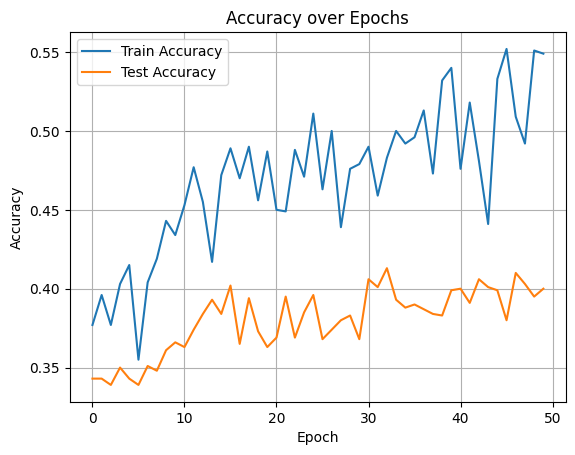

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 트랜스포머 정확도 비교

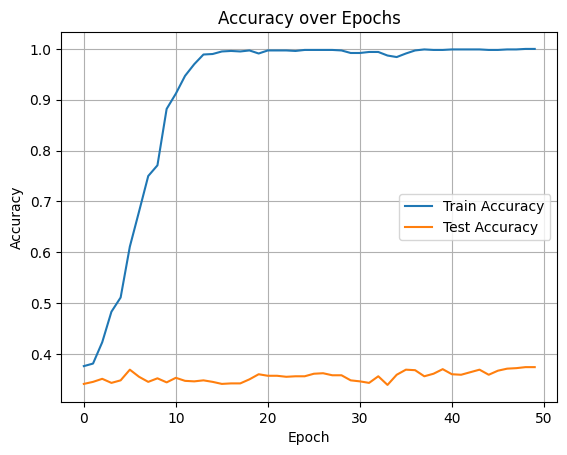

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_accs2, label='Train Accuracy')
plt.plot(test_accs2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## 트랜스포머 loss 커브

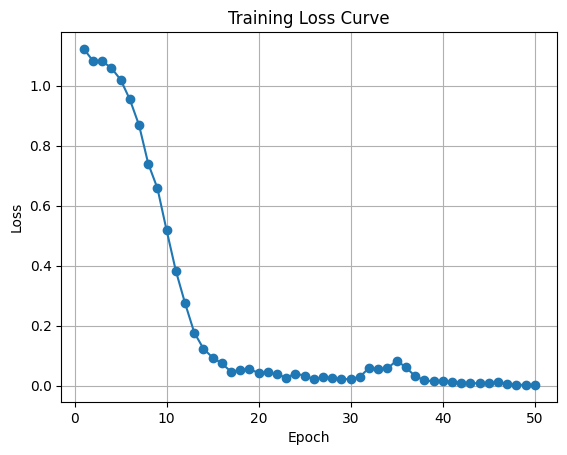

In [18]:
plt.plot(range(1, n_epochs+1), train_losses2, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## BERT 로스 커브

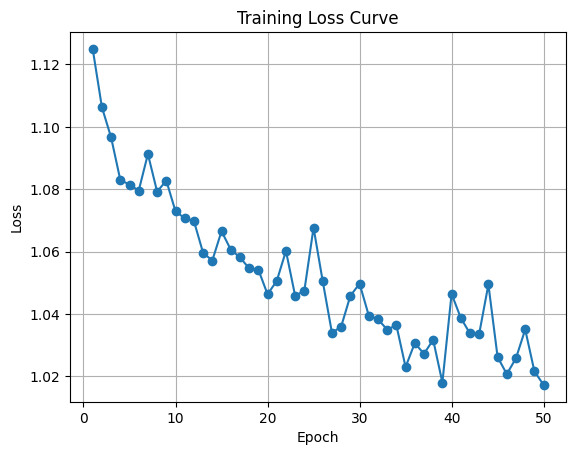

In [ ]:
plt.plot(range(1, n_epochs+1), train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


사전학습 BERT 샘플 테스트

In [ ]:

from torch.nn.functional import softmax
index = 5
# 테스트 샘플 하나 꺼내기
sample = test_data[index]

#라벨
label_map = {
    0: "entailment(지지)",
    1: "neutral(중립)",
    2: "contradiction(모순)"
}


premise = sample['premise']
hypothesis = sample['hypothesis']
true_label = sample['label']

encoded = tokenizer(premise, hypothesis, return_tensors='pt', truncation=True, padding=True, max_length=256)
input_ids = encoded['input_ids'].to('cuda')
attention_mask = encoded['attention_mask'].to('cuda')

# 예측
model.eval()
with torch.no_grad():
    logits = model(input_ids)
    pred_class = logits.argmax(dim=-1).item()  # 예측 클래스 인덱스
    # softmax로 확률 분포 체크
    probs = softmax(logits, dim=-1)[0].tolist()


# 출력
print("🟦 전제:")
print(premise)
print("\n🟦 가설:")
print(hypothesis)
print("\n🟩 정답 라벨:", f"{true_label} ({label_map.get(true_label)})")
print("🟥 예측 라벨:", f"{pred_class} ({label_map.get(pred_class)})")

print("\n📊 예측 확률 분포:")
for i, prob in enumerate(probs):
    print(f"  {label_map.get(i)}: {prob:.3f}")

🟦 전제:
well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be

🟦 가설:
We have plenty of space in the landfill.

🟩 정답 라벨: 2 (contradiction(모순))
🟥 예측 라벨: 2 (contradiction(모순))

📊 예측 확률 분포:
  entailment(지지): 0.136
  neutral(중립): 0.300
  contradiction(모순): 0.565
